In [39]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
import sparsipy
import copy
import time

plt.style.use('ggplot')

# Two minor differences compared to AdaBoost
# 1. computation of alpha_t
# 2. final hypothesis have alphas normalized and does not use sign. 

# The algorithm takes "two parameters": 
# T: # hypothesis
# v: desired accuracy
# where T = 2*log(n)/v^2 ;; in this we only give T and then compute v by v=\sqrt(lg(n)/t)

#TODO:
# add parameter 'compute_minimal_margins' which is automatically true if visualize is true. Setting this 
# parameter to false will increase speed significantly because we don't have to compute margin at 
# each iteration. 
class AdaBoostV():
    """
        AdaBoostV:    http://www.jmlr.org/papers/volume6/ratsch05a/ratsch05a.pdf
        Two minor differences compared to the original AdaBoost algorithm. 
        - Computation of alphas_t 
        - The final hypothesis is normalized as does not use sign. 
    
    
        Core functions:
            fit
            predict
            sparsify
            minimal_margin
    """
    
    def __init__(self, debug=False, visualize=False, print_progress = False, timing=False,
                 compute_margins = False, pre_normalize=False, 
                 post_normalize=False, limit=80, color='g'):
        self.reset()
        self.debug           = debug
        self.visualize       = visualize 
        self.pre_normalize   = pre_normalize
        self.post_normalize  = post_normalize
        self.minimal_margins = []
        self.v               = None
        self.limit           = limit
        self.compute_margins = compute_margins
        self.print_progress  = print_progress
        self.timing          = timing
        self.force_silent    = False
        
        # used for kangaroo training
        self.retrained_minimal_margins = []
        self.retrained       = []
        
        if self.visualize: 
            self.rho_estimates = []
            self.xs = []
            self.color = color
            self.fig_ax_tupple = plt.subplots(1, 2, figsize=(10,5))
            self.compute_margins = True
            
    def reset(self):
        """ Resets field variables. This is called by fit before training to ensure a fresh/clean training. """
        self.estimators      = []
        self.alphas          = []
        self.sample_weight   = None
        self.edges = []
    
    def growing_kangaroo_fit(self, X, y, T, repeat, grow=5, stop=-1):
        """ Fit AdaBoostV normally to T hypothesis. 
            Sparsify down as far as possible, retrain to T hypothesis. 
            Pick the best and repeat 'repeat' times. 
        """
        self.fig_ax_tupple = plt.subplots(1, 2, figsize=(10,5)) # make this a bit nicer
        self.color = '-go'
        self.force_silent = True
        
        target = 5
        
        # Train initially to T hypothesis. 
        self.fit(X, y, T)
        self.direct_mm = self.minimal_margin(X, y)
        self.repeat_mm = []
        self.repeat_xs = []
        print("Initial: \t (%i, %f)"%(T, self.direct_mm))
                
        for i in range(repeat):
            # stop if we are close to getting to many hypothesis
            if stop > 0 and stop < T+grow*i: break
                
            # sparisfy to target hypothesis
            self.sparsify(X, y, 5, T=T+int(grow*i))

            # store all results in self.retrained
            best_index = np.argmax(np.array(self.retrained_minimal_margins))
            best_retrained = self.retrained[best_index]
            
            self = self.retrained[best_index]
            best_mm = np.max(self.retrained_minimal_margins)
            self.repeat_mm.append(best_mm)
            self.repeat_xs.append(T+int(grow*i))
            
            print("Step %i:\t (%i, %f)"%(i, T+int(grow*i), best_mm))
            self.visualize_growing_kangaroo_step()
    
    
    def visualize_growing_kangaroo_step(self):
         # Update the plot. 
        self.fig_ax_tupple[1][0].plot(self.repeat_xs, self.repeat_mm, self.color)
        self.fig_ax_tupple[1][0].plot(range(len(self.repeat_mm)), np.array([self.direct_mm]*len(self.repeat_mm)))
        self.fig_ax_tupple[1][0].set_xlabel("# repeats")
        self.fig_ax_tupple[1][0].set_ylabel("Minimal Margin")
        self.fig_ax_tupple[1][0].set_title("Kangaroo AdaBoostV")
        self.fig_ax_tupple[0].canvas.draw()
     
    def kangaroo_fit(self, X, y, T, repeat):
        """ Fit AdaBoostV normally to T hypothesis. 
            Sparsify down as far as possible, retrain to T hypothesis. 
            Pick the best and repeat 'repeat' times. 
        """
        self.fig_ax_tupple = plt.subplots(1, 2, figsize=(10,5)) # make this a bit nicer
        self.color = '-go'
        self.force_silent = True
        
        target = 5
        
        # Train initially to T hypothesis. 
        self.fit(X, y, T)
        self.direct_mm = self.minimal_margin(X, y)
        self.repeat_mm = []
                
        for i in range(repeat):
            # sparisfy to target hypothesis
            self.sparsify(X, y, 5)

            # store all results in self.retrained
            best_index = np.argmax(np.array(self.retrained_minimal_margins))
            best_retrained = self.retrained[best_index]
            
            print("Minimal Margin: ", np.max(self.retrained_minimal_margins))
            
            self = self.retrained[best_index]
            self.repeat_mm.append(np.max(self.retrained_minimal_margins))
            
            self.visualize_kangaroo_step()
            
    def visualize_kangaroo_step(self):
         # Update the plot. 
        self.fig_ax_tupple[1][0].plot(range(1, len(self.repeat_mm)+1), self.repeat_mm, self.color)
        self.fig_ax_tupple[1][0].plot(range(1,len(self.repeat_mm)+1), np.array([self.direct_mm]*len(self.repeat_mm)))
        self.fig_ax_tupple[1][0].set_xlabel("# repeats")
        self.fig_ax_tupple[1][0].set_ylabel("Minimal Margin")
        self.fig_ax_tupple[1][0].set_title("Kangaroo AdaBoostV")
        self.fig_ax_tupple[0].canvas.draw()
        
    
    def fit(self, X, y, T):
        """
        
        Parameters
        ----------
        X:     Matrix of size (n, d) with data point x_i as the i'th row. 
        y:     Array of size (n, ) with label y_i as the i'th entry. 
        T:     Iterations to run the algorithm for. In the JLMR paper, the user supplies both approximation
               parameter v and iterations T. Here we compute approximation parameter as v=sqrt(2*ln(n)/T).
        
        TODO: make visualize a function that is called by step. 
        plot:  Holds an array of (fig, ax)
        color: 
        
        Returns
        -------
        margins: A list containing minimal margin of each iteration. 
        
        """
        n, d = X.shape
        
        # Check labels are {-1, +1} and not {0, 1}
        assert set(y) == {-1, +1}, ("Labels should be {-1, +1} and not ", set(y))
        
        # Make sure we didn't store any estimators/weights from previous iterations.
        self.reset()
        
        # differ; TODO: read paper and understand how we set approximation parameter. 
        self.v = np.sqrt(2*np.log(n) / T)
        print("Setting approximation parameter v=\sqrt(2\log(n) / T): ", self.v, "\n")
        
        # Start with uniform distribution as sample weight
        self.sample_weight = np.ones(n) / n 
        
        # Take T steps of AdaBoostV;
        self.step_to(X, y, T)

        
    def step(self, X, y):
        """ Perform one iteration of AdaBoostV. This will add 
        - one hypothesis h_t to self.estimators,
        - one weight alpha_t to self.alphas 
        - one edge    edge_t to self.edges
        
         Parameters
        ----------
        X:     Matrix of size (n, d) with data point x_i as the i'th row. 
        y:     Array of size (n, ) with label y_i as the i'th entry. 
        
        """
        # Make sure that sample weight is a distribution; sum to 1 and >=0. 
        assert np.allclose(np.sum(self.sample_weight), 1.0), np.sum(self.sample_weight)
        assert sum(self.sample_weight >= 0) == self.sample_weight.shape[0]
        
        # Learn weak DT classifier on weighed data weighed according to sample_weight
        h_t  = DecisionTreeClassifier(max_depth=2)
        h_t.fit(X, y, sample_weight=self.sample_weight)
        
        # Compute the edge of hypothesis h_t and add to list (step b in Algorithm 2)
        edge_t = np.sum( self.sample_weight * y * h_t.predict(X)) 
        self.edges.append(edge_t)
       
        # Find the minimal edge so far and compute current estimate 'rho_t' of optimal 
        # minimal margin (step d in Algorithm 2)
        edge_min = np.min(self.edges)
        rho_t = edge_min - self.v
        
        # Compute the weight for hypothesis h_t (step e in Algorithm 2)
        edge_part =  1/2 * np.log( (1+edge_t) / (1-edge_t) ) 
        rho_part  =  1/2 * np.log( (1+rho_t)  / (1-rho_t)  )
        alpha_t = edge_part - rho_part
    
        # Append estimator and weight to list. 
        self.estimators.append(h_t)
        self.alphas.append(alpha_t)

        # Update sample weight (step f in Algorithm 2)
        self.sample_weight = self.sample_weight * np.exp(- alpha_t * y * h_t.predict(X) )
        self.sample_weight = self.sample_weight / np.sum(self.sample_weight)
        
        # If DT perfectly classifies the weighed data set we are done (step c in Algorithm 3)
        # Moved to end because this is not really the case we are interested in. 
        if np.abs(edge_t) == 1.0: 
            #assert False, "Edge was 1.0, perfect classification, this actually happens?" 
            print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
            print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
            print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!PERFECT!!!!!!!!!!!!!!!!!!!!!!!")
            print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
            print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
            
        
        
    def step_to(self, X, y, T):
        """ Performs AdaBoostV steps until we reach T hypothesis. """
        n, d = X.shape
        
        # Compute how many hypothesis we need to add. 
        current_hypothesis = len(self.alphas)
        remaining = T - current_hypothesis
        
        # Start timing if enabled. 
        if self.timing: self.time0 = time.time()
 
        # Take the AdaBoostV steps that remain before we reach T hypothesis. 
        for i in range(remaining): 
            # Compute and add minimal margin if enabled
            if self.compute_margins and len(self.alphas) > 0: self.minimal_margins.append(self.minimal_margin(X, y))
            # Visualize if enabled
            if self.visualize and len(self.alphas) > 0: self.visualize_step(X, y)
            # Print progress
            if self.print_progress: self.do_print_progress(i, remaining)
            
            # Boost one step
            self.step(X, y)   
        
        # Stop timing if enabled
        if self.timing: self.time1 = time.time()
            
        # Compute and add minimal margin if enabled
        if self.compute_margins and len(self.alphas) > 0: self.minimal_margins.append(self.minimal_margin(X, y))
        # Visualize final iteration if enabled, save figure because last step. 
        if self.visualize: self.visualize_step(X, y, save=True)
        # Print done 
        if self.print_progress: self.do_print_progress(remaining, remaining, True)

    
    def do_print_progress(self, i, remaining, last=False):
        # we have 80 '=', compute percentages
        percentages = i / remaining
        done_num = int(percentages * 60)
        space_num = 60 - done_num-2
        
        print("\r" + " "*80, end='')
        progress_string = "[" + "="*done_num + ">" + " "*space_num + "]\t" + str(round(percentages*100, 3)) + "%"
        
        print("\r" + progress_string, end='')
        
        if self.timing: 
            time_consumption = str(round(time.time() - self.time0, 3))
            print("\t" + time_consumption + "s", end='', flush=True)
                    
        if last:
            print("\r" + " "*120, end='')
            print("\r[" + "="*done_num + ">]\tDONE!\t" + time_consumption + "s", flush=True)
            
            
    
    def visualize_step(self, X, y, save=False):
        """ Plot the minimal margin and current rho estimate at an iteration of AdaBoostV. 
        """
        # Count current number of hypothesis
        current_hypothesis_count = len(self.alphas)
        
        # Add current hypothesis count as x value for plotting. 
        self.xs.append(current_hypothesis_count)
            
        # Compute current estimat of rho; add the [1] in min
        # because this could be called when self.edges is eempty 
        # and 1 is the worst value of edge. 
        rho_t = np.min(self.edges + [1]) - self.v
        self.rho_estimates.append(rho_t)
                            
        # Update the plot. 
        self.fig_ax_tupple[1][0].plot(self.xs, self.minimal_margins, self.color)
        self.fig_ax_tupple[1][0].set_xlabel("# hypothesis")
        self.fig_ax_tupple[1][0].set_ylabel("Minimal Margin")
        self.fig_ax_tupple[1][0].set_title("AdaBoostV w/ Sparsification")
        self.fig_ax_tupple[1][1].plot(self.xs, self.rho_estimates, self.color)
        self.fig_ax_tupple[1][1].set_xlabel("# hypothesis")
        self.fig_ax_tupple[1][1].set_ylabel("Rho Estimate")
        self.fig_ax_tupple[1][1].set_title("AdaBoostV 'rho' estimate")
        self.fig_ax_tupple[0].canvas.draw()
        
        
        # SAVE PLOT SOMEHOW!
        if save: 
            pass
        #fig_ax_tupple = plt.subplots(1, 2, figsize=(10,5)) 
        #self.ffig_ax_tupple[0].savefig("figures/" + title)
        #self.fig_ax_tupple[0].canvas.draw()
        
    def predict(self, X):
        """ Returns the predicted labels for the given data. 
        
        Parameters
        ----------
        X:     Matrix of size (n, d) with data point x_i as the i'th row. 
        
        Returns
        -------
        pred:  Array of size (n, ) where the i'th entry has the prediction of x_i. 
        
        """
        n, d = X.shape
        
        # Predictions is similar to original AdaBoost, but unsigned with normalized weights (alpha). 
        pred = [self.alphas[t]*self.estimators[t].predict(X) for t in range(len(self.estimators))]
        pred = np.sum(pred, axis=0)
        
        assert pred.shape == (n, ), pred.shape
        return pred / np.sum(self.alphas)
    
    def margins(self, X, y):
        """ Compute margins. The margin of a data point x_i is defined as
        
            margin(x_i) := y_i * H(x) = y_i * sum_t alpha_t h_t(x) / sum_t alpha_t
        
        where the last part is just normalizing alphas. Notice predict takes care of 
        normalization so we do not have to do it here. 
        
        Parameters
        ----------
        X:     Matrix of size (n, d) with data point x_i as the i'th row. 
        y:     Array of size (n, ) with label y_i as the i'th entry. 
        
        Returns
        -------
        pred:  Array of size (n, ) where the i'th entry has the prediction of x_i. 
        """
        return y * self.predict(X)

    def minimal_margin(self, X, y):
        """ Returns the minimal margin. """
        return np.min(self.margins(X, y))
    
    def sparsify(self, X, y, target, T=0):
        """ Assumes fit has already been called. Uses data to sparsify the AdaBoostV ensemble
        into fewer hypothesis while preserving minimal margin up to \sqrt(\log(n/t)/t). 
                                                         
        Parameters
        ----------
        X:     Matrix of size (n, d) with data point x_i as the i'th row. 
        y:     Array of size (n, ) with label y_i as the i'th entry. 
        """
        n, d = X.shape
        
        # Compute the game matrix U such that U_ij = h_j(x_i)
        U = self.compute_matrix(X, y)
        if T == 0: n, T = U.shape  # if T not specified take from U
            
        # Normalize before sparisfying 
        # self.alphas = self.alphas / np.sum(self.alphas)
        
        # Call the sparisifaction code with game matrix U and weights
        if self.timing: self.sparsify_time0 = time.time()
        w = sparsipy.sparsify(U, self.alphas, target)
        if self.timing and not self.force_silent: print("Sparsification: " + str(round(time.time()-self.sparsify_time0, 3)) + "s")
        
        # TODO: How should we set theese guys?
        #self.v = np.sqrt(2*np.log(n/T) / T) ;; This value is not what we would expect, wrong calculation.
        self.edges = []
        
        # Get the minimal margin of training direct; 
        # Re-compute because it will only be stored in self.minimal_margins if visualize=True!
        direct_mm = self.minimal_margin(X, y)
        if not self.force_silent: print("Direct AdaBoostV: \t\t", direct_mm, "\n")
    
        # Each iteration of the above sparsification yields a set of weights. 
        # For each set of weights try train up to T hypothesis and see how well it performs. 
        for i in range(len(w)-1, 0, -1):
            
            # Count how many hypothesis with non-zero weight after sparsification.
            # If less than 80 just stop. 
            non_zero = sum(w[i] != 0)
            if non_zero > self.limit: break
            
            # Copy the pre-trained AdaBoostV object we while overwrite with new weights. 
            current_ada = copy.deepcopy(self)
            
            # if we draw new guys make them different color
            if self.visualize: current_ada.color = '-b'  # TODO: change to different colors and add legends
            
            # Pair the non-zero weight entries with their corresponding estimator.  
            lists = []
            for j in range(w.shape[1]):
                lists.append( (w[i][j], current_ada.estimators[j]) )
            lists = sorted(lists, key = lambda x: x[0], reverse=True)
            
            # Update AdaBoostV copy to hold new weights and corresponding estimators. 
            current_ada.estimators = [tupple[1] for tupple in lists if tupple[0] > 0.0] 
            current_ada.alphas     = [tupple[0] for tupple in lists if tupple[0] > 0.0]

            # Remove. 
            #if current_ada.post_normalize == True: 
            #current_ada.alphas = list(current_ada.alphas / np.sum(current_ada.alphas))
            
            # Update sample_weight; not that self.margins(X, y) uses self.predict(X) which
            # normalizes the alphas. The JLMR article does not normalizate! 
            # (if we normalize above it maes no difference, the normalization step of predict
            # will just do nothing because self.alpha already sums to one. )
            unnormalized_predictions = [current_ada.alphas[t]*current_ada.estimators[t].predict(X) for t in range(len(current_ada.estimators))]
            unnormalized_predictions = np.sum(unnormalized_predictions, axis=0)
            unnormalized_margins = y * unnormalized_predictions
            
            current_ada.sample_weight = np.exp(- unnormalized_margins) 
            current_ada.sample_weight = current_ada.sample_weight / np.sum(current_ada.sample_weight)
            
            # Would this make a difference?
            if False:
                current_ada.sample_weight = np.ones(n)/n # I don't think this make any difference when we normalize afterwards?
                current_ada.sample_weight = current_ada.sample_weight * np.exp(- unnormalized_margins) 
                current_ada.sample_weight = current_ada.sample_weight / np.sum(current_ada.sample_weight)
           
            # Print number of hypothesis after sparsification, initial minimal margin, and
            # corresponding minimal if we trained directly to this number of hypothesis. 
            if self.compute_margins: 
                if not self.force_silent: print("Sparsify %i gave margin: \t"%(non_zero), current_ada.minimal_margin(X, y), "\t(%f)"%self.minimal_margins[non_zero])
            else:     
                if not self.force_silent: print("Sparsify %i gave margin: \t"%(non_zero), current_ada.minimal_margin(X, y))
            
            # Train from current number of hypothesis up to T hypothesis. 
            current_ada.step_to(X, y, T)
            current_mm = current_ada.minimal_margin(X, y)
            
            # Add new AdaBoost object and minimal margin to lists. 
            self.retrained.append(current_ada)
            self.retrained_minimal_margins.append(current_mm)
            
            # Print the results. 
            if not self.force_silent: print("Train %i -> %i gave margin: \t"%(non_zero, T), current_mm)   
            
            # Print who won. 
            diff = np.abs(direct_mm - current_mm)
            if not self.force_silent: print("Absolute Difference: \t\t", diff)
            if direct_mm < current_mm: 
                if not self.force_silent: print("Winner: OUR ALGORITHM!")
            else:
                if not self.force_silent: print("Winner: AdaBoostV!")
            
            if not self.force_silent: print("")
        
    def compute_matrix(self, X, y): 
        '''
        Compute matrix U such that U_ij = h_j(x_i)
        Notice U will have size n x T
        '''
        T = len(self.alphas)
        n, d = X.shape
        U = np.zeros( (n, T) )
        
        for i in range(T):
            U[:, i] = self.estimators[i].predict(X)
            
        return U
    
    
    def score(self, X, y):
        n, d = X.shape
        pred = np.sign(self.predict(X))
        return sum(pred == y) / n
    
    def __deepcopy__(self, memo):
        shallow_copy = copy.copy(self)
        shallow_copy.alphas = copy.deepcopy(self.alphas)
        shallow_copy.estimators = copy.deepcopy(self.estimators)
        
        # override xs and minimal_margins
        shallow_copy.xs = []
        shallow_copy.minimal_margins = []
        shallow_copy.rho_estimates = []
        shallow_copy.edges = []
        
        return shallow_copy

# Sanity check: compare AdaBoostV with SKlearns AdaBoost

In [40]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification

X, y = make_classification(1000, 5, n_classes=2)
y = y*2-1

T = 100
sklearn_ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2),  algorithm="SAMME", n_estimators=T)
sklearn_ada.fit(X, y)

alex_ada = AdaBoostV()
alex_ada.fit(X, y, T)

print("Sklearn: \t", sklearn_ada.score(X, y))
print("Alex: \t\t", alex_ada.score(X, y)) 

Setting approximation parameter v=\sqrt(2\log(n) / T):  0.371692218885 

Sklearn: 	 0.975
Alex: 		 1.0


# Train AdaBoostV and plot minimal margin

<IPython.core.display.Javascript object>


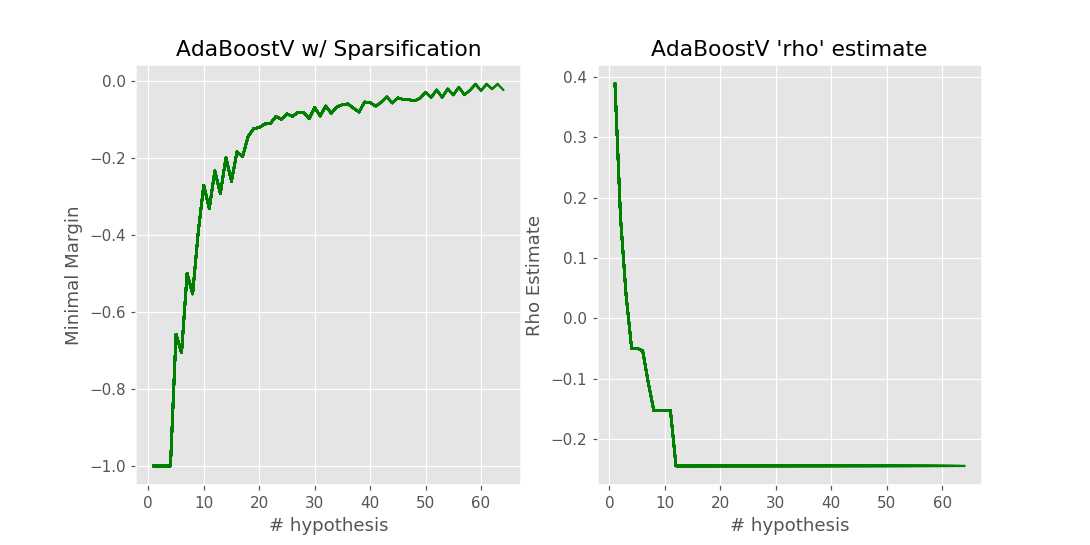

Setting approximation parameter v=\sqrt(2\log(n) / T):  0.465412176382 

[============================================================>]	DONE!	4.925s                                            


In [42]:
from sklearn.datasets import make_classification

X, y = make_classification(1024, 5, n_classes=2)
y = y*2-1
    
T = 64
ada = AdaBoostV(visualize=True, print_progress=True, timing=True) 
    
ada.fit(X, y, T)

# Train AdaBoostV and sparsify/retrain

<IPython.core.display.Javascript object>


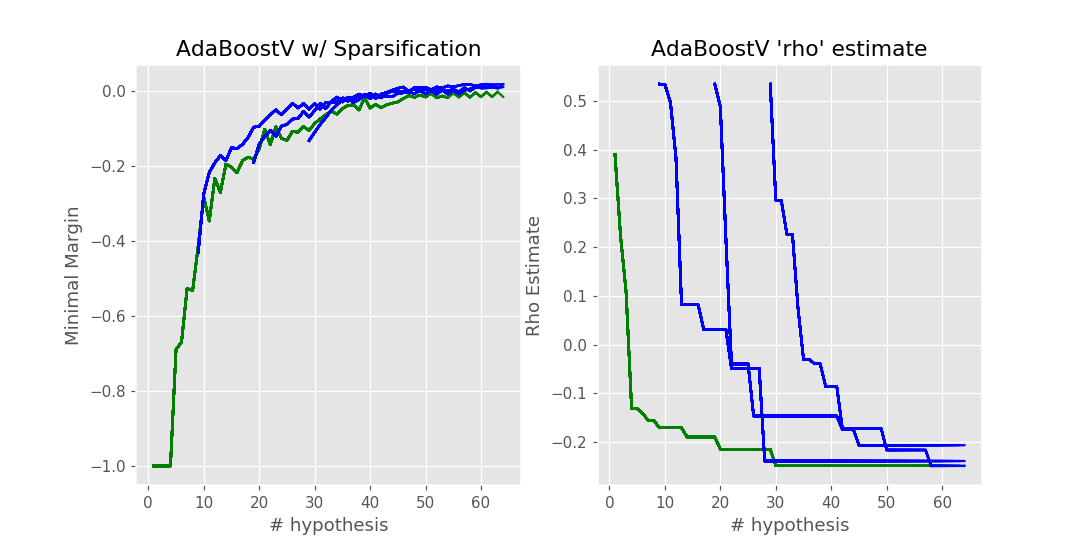

Setting approximation parameter v=\sqrt(2\log(n) / T):  0.465412176382 

[============================================================>]	DONE!	4.77s                                             
Sparsification: 0.676s
Direct AdaBoostV: 		 -0.0170577615376 

Sparsify 9 gave margin: 	 -0.43166780842 	(-0.283670)
[============================================================>]	DONE!	5.272s                                            
Train 9 -> 64 gave margin: 	 0.00922539067623
Absolute Difference: 		 0.0262831522139
Winner: OUR ALGORITHM!

Sparsify 19 gave margin: 	 -0.192123854984 	(-0.155563)
[============================================================>]	DONE!	4.451s                                            
Train 19 -> 64 gave margin: 	 0.01640019775
Absolute Difference: 		 0.0334579592877
Winner: OUR ALGORITHM!

Sparsify 29 gave margin: 	 -0.133310746773 	(-0.087664)
[============================================================>]	DONE!	3.772s                                         

In [43]:
from sklearn.datasets import make_classification

X, y = make_classification(1024, 5, n_classes=2)
y = y*2-1
    
T = 64
ada = AdaBoostV(visualize=True, print_progress=True, timing=True) 
    
ada.fit(X, y, T)
ada.sparsify(X, y, 10)

# (Large) Train AdaBoostV and sparsify/retrain

In [44]:
from sklearn.datasets import make_classification

X, y = make_classification(4000, 5, n_classes=2)
y = y*2-1
    
T = 512
ada = AdaBoostV(print_progress=True, timing=True, limit=200) 
    
ada.fit(X, y, T)
ada.sparsify(X, y, 10)

Setting approximation parameter v=\sqrt(2\log(n) / T):  0.179996198312 

[=====================>                                     ]	36.328%	3.176s    

KeyboardInterrupt: 

# TODO: Datasets from AdaBoostV article 

In [ ]:
# find datasets, maybe they are in sklearn?

# Kangaroo Boosting

<IPython.core.display.Javascript object>


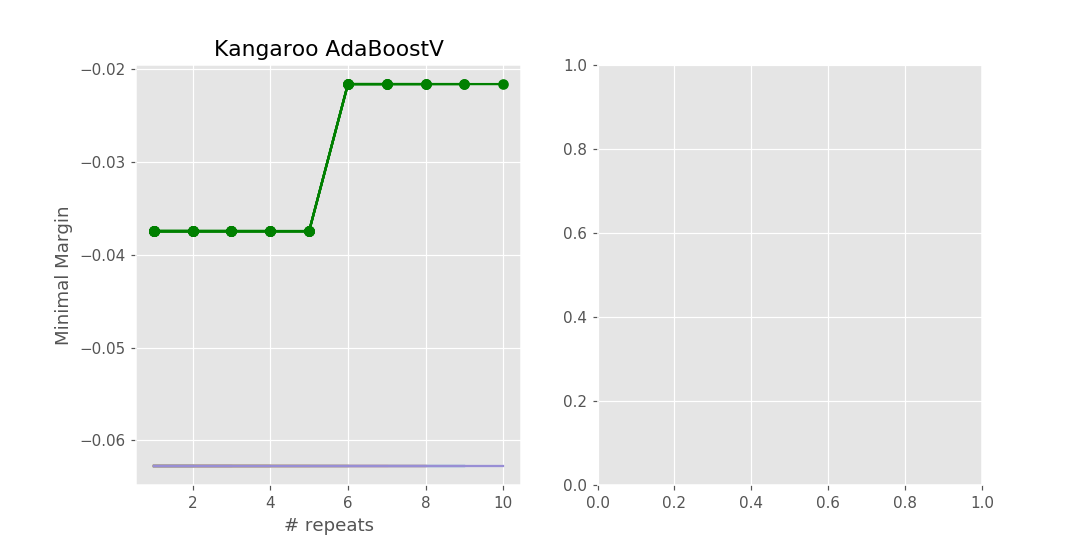

Setting approximation parameter v=\sqrt(2\log(n) / T):  0.509106129656 

[============================================================>]	DONE!	1.079s                                            
[============================================================>]	DONE!	1.01s                                             
[============================================================>]	DONE!	0.879s                                            
[============================================================>]	DONE!	0.508s                                            
Minimal Margin:  -0.0374520556563
[============================================================>]	DONE!	0.919s                                            
[============================================================>]	DONE!	0.831s                                            
[============================================================>]	DONE!	0.565s                                            
Minimal Margin:  -0.0374520556563
[===========

In [45]:
from sklearn.datasets import make_classification

X, y = make_classification(4000, 5, n_classes=2)
y = y*2-1
    
T = 64
repeat = 10
ada = AdaBoostV(print_progress=True, timing=True) 
    
ada.kangaroo_fit(X, y, T, repeat=repeat)

# Growing Kangaroo Boosting (small, compare with others)

<IPython.core.display.Javascript object>


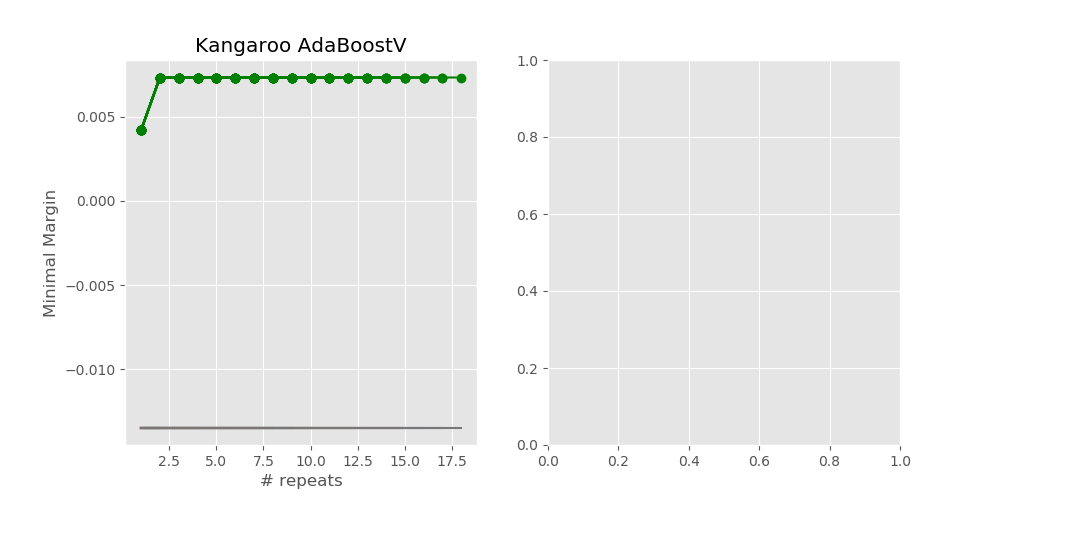

Setting approximation parameter v=\sqrt(2\log(n) / T):  0.371692218885 

[============================================================>]	DONE!	0.553s                                            
[============================================================>]	DONE!	0.671s                                            
[============================================================>]	DONE!	0.571s                                            
[============================================================>]	DONE!	0.524s                                            
[============================================================>]	DONE!	0.395s                                            
[============================================================>]	DONE!	0.314s                                            
Minimal Margin:  0.00418788336408
[============================================================>]	DONE!	0.648s                                            
[=============================================

[============================================================>]	DONE!	0.624s                                            
[============================================================>]	DONE!	0.544s                                            
[============================================================>]	DONE!	0.4s                                              
[============================================================>]	DONE!	0.324s                                            
Minimal Margin:  0.00732792645858
[============================================================>]	DONE!	0.547s                                            
[============================================================>]	DONE!	0.604s                                            
[============================================================>]	DONE!	0.538s                                            
[============================================================>]	DONE!	0.423s                                           

<IPython.core.display.Javascript object>


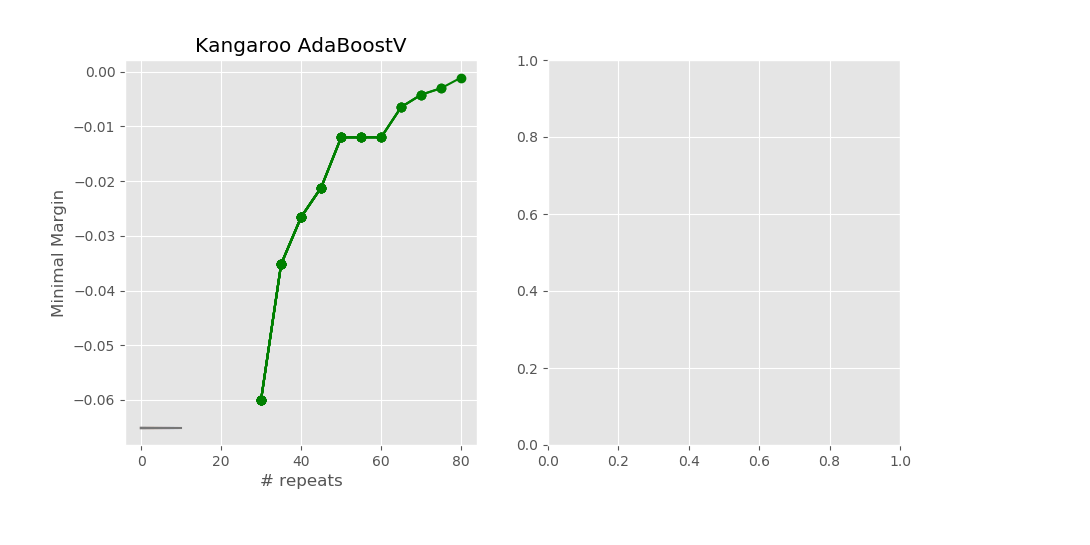

Setting approximation parameter v=\sqrt(2\log(n) / T):  0.678614042442 

[============================================================>]	DONE!	0.162s                                            
Initial: 	 (30, -0.065034)
[============================================================>]	DONE!	0.223s                                            
[============================================================>]	DONE!	0.117s                                            
Step 0:	 (30, -0.059923)
[============================================================>]	DONE!	0.258s                                            
[============================================================>]	DONE!	0.174s                                            
[============================================================>]	DONE!	0.118s                                            
Step 1:	 (35, -0.035191)
[============================================================>]	DONE!	0.273s                                            
[==

/home/ubudevml/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:230: RuntimeWarning: divide by zero encountered in double_scalars
/home/ubudevml/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:240: RuntimeWarning: invalid value encountered in true_divide


AssertionError: nan

In [48]:
from sklearn.datasets import make_classification

X, y = make_classification(1000, 5, n_classes=2)
y = y*2-1

T = 100
repeats = 18
    
#ada_direct = AdaBoostV(print_progress=True, timing=True, visualize=True, limit=10)
#ada_direct.fit(X, y, T)
#ada_direct.sparsify(X, y, 10)
    
ada_kangaroo = AdaBoostV(print_progress=True, timing=True, visualize=False)
ada_kangaroo.kangaroo_fit(X, y, T, repeat=repeats)

ada = AdaBoostV(print_progress=True, timing=True) 
ada.growing_kangaroo_fit(X, y, 30, repeats, grow=5, stop=T) 